In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision

torch.Size([400, 640])


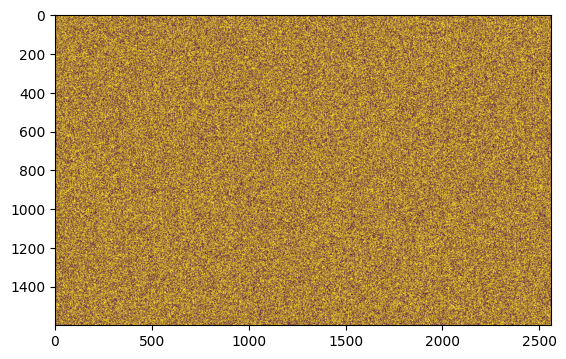

In [9]:
# load the tensor saved
def load_tensor(f):
    t = torch.jit.load(f)
    for _, p in t.named_parameters():
        return p

t = load_tensor('tensor.pt').to(("cuda"))
print(t.shape)

def quantize(tt : torch.Tensor)->torch.Tensor:
    m_table = torch.Tensor([
        0.0000, 0.0100, 0.0205, 0.0422,
        0.0560, 0.0727, 0.1131, 0.1734,
        0.3426, 0.3707, 0.4228, 0.4916,
        0.5994, 0.6671, 0.7970, 0.9375
    ]).to(tt.device)

    m_levels = m_table.to(tt.dtype).view([1, -1])
    tt = (tt + torch.pi) / (2 * torch.pi)
    flat_x = tt.view([-1])

    diffs = torch.remainder(flat_x.unsqueeze(1) - m_levels + 0.5, 1.0) - 0.5
    indicies = torch.argmin(diffs.abs(),1)

    return indicies.view_as(tt)

t = t.unsqueeze(0).repeat([20, 1, 1]).to(torch.float32)

def upscale_blocks(x: torch.Tensor, scale_h: int, scale_w : int) -> torch.Tensor:
    """
    Upscales a 2D tensor x by repeating each 2x2 block in a grid fashion,
    so that the output is (target_size, target_size).
    Assumes target_size is divisible by x.shape[0] and x.shape[1], and by 2.
    """
    h, w = x.shape
    H, W = h * scale_h, w * scale_w

    # Extract 2x2 blocks
    x_blocks = x.unfold(0, 2, 2).unfold(1, 2, 2)  # (h//2, w//2, 2, 2)
    # Repeat each block in a (scale, scale) grid
    x_blocks = x_blocks.repeat_interleave(scale_h, dim=0).repeat_interleave(scale_w, dim=1)  # (h//2*scale, w//2*scale, 2, 2)
    # Rearrange to reconstruct the full array
    out = x_blocks.permute(0,2,1,3).reshape(H, W)
    return out

def MEncode_u8Tensor3(tt : torch.Tensor, m_h=1600,m_w=2560)->torch.Tensor:
    N, input_H, input_W = tt.shape

    masks = torch.Tensor([
        [[1, 0], [1, 0]],  # 0
        [[1, 0], [0, 0]],  # 1
        [[0, 0], [1, 0]],  # 2
        [[1, 0], [1, 1]],  # 3
        [[0, 0], [0, 0]],  # 4
        [[1, 0], [0, 1]],  # 5
        [[0, 0], [1, 1]],  # 6
        [[0, 0], [0, 1]],  # 7
        [[1, 1], [1, 0]],  # 8
        [[1, 1], [0, 0]],  # 9
        [[0, 1], [1, 0]],  #10
        [[0, 1], [0, 0]],  #11
        [[1, 1], [1, 1]],  #12
        [[1, 1], [0, 1]],  #13
        [[0, 1], [1, 1]],  #14
        [[0, 1], [0, 1]]   #15
    ]).to(tt.device)

    shifts = torch.Tensor( 
    [
        (1 << 0),  (1 << 1),
        (1 << 2),  (1 << 3),
        (1 << 4),  (1 << 5),
        (1 << 6),  (1 << 7),
        (1 << 8),  (1 << 9),
        (1 << 10), (1 << 11),
        (1 << 12), (1 << 13),
        (1 << 14), (1 << 15),
        (1 << 16), (1 << 17),
        (1 << 18), (1 << 19),
        (1 << 20), (1 << 21),
        (1 << 22), (1 << 23)
    ]).to(tt.device).to(torch.int32)

    plane = quantize(tt)
    logical = masks.index_select(0, plane.view([-1]))
    logical = logical.view([N, input_H, input_W, 2, 2])
    logical = logical.permute([0, 1, 3, 2, 4]).contiguous()
    encoded = logical.view([N, input_H * 2, input_W * 2])
    shifts_used = shifts[:N].to(tt.device).view(N, 1, 1)
    encoded = encoded.to(torch.int32)
    image = torch.sum(encoded * shifts_used, 0)

    raw_h, raw_w = image.shape
    scale_h, scale_w = m_h // raw_h, m_w // raw_w

    #upscaled = image.unsqueeze(0).repeat_interleave(scale_h,1).repeat_interleave(scale_w,2).squeeze(0)
    upscaled = upscale_blocks(image, scale_h, scale_w)
    return upscaled

def MDecode_u8Tensor3(tt : torch.Tensor) -> torch.Tensor:
    masks = torch.Tensor([
        [[1, 0], [1, 0]],  # 0
        [[1, 0], [0, 0]],  # 1
        [[0, 0], [1, 0]],  # 2
        [[1, 0], [1, 1]],  # 3
        [[0, 0], [0, 0]],  # 4
        [[1, 0], [0, 1]],  # 5
        [[0, 0], [1, 1]],  # 6
        [[0, 0], [0, 1]],  # 7
        [[1, 1], [1, 0]],  # 8
        [[1, 1], [0, 0]],  # 9
        [[0, 1], [1, 0]],  #10
        [[0, 1], [0, 0]],  #11
        [[1, 1], [1, 1]],  #12
        [[1, 1], [0, 1]],  #13
        [[0, 1], [1, 1]],  #14
        [[0, 1], [0, 1]]   #15
    ]).to(tt.device)

    H, W = tt.shape
    tt_blocks = tt.unfold(0, 2, 2).unfold(1, 2, 2)  # shape: (H//2, W//2, 2, 2)
    blocks = tt_blocks.contiguous().view(-1, 2, 2)   # (num_blocks, 2, 2)
    masks_flat = masks.view(16, 4)                   # (16, 4)
    blocks_flat = blocks.view(-1, 4)                 # (num_blocks, 4)

    # Compare each block to each mask, get (num_blocks, 16) boolean matrix
    eq = (blocks_flat.unsqueeze(1) == masks_flat.unsqueeze(0))  # (num_blocks, 16, 4)
    matches = eq.all(-1)  # (num_blocks, 16)
    phase_value = matches.float().argmax(1).view(H//2, W//2)
    return phase_value

u = MEncode_u8Tensor3(t) & 0x1
z = MDecode_u8Tensor3(u)

plt.imshow(u.cpu().detach().numpy())
plt.show()


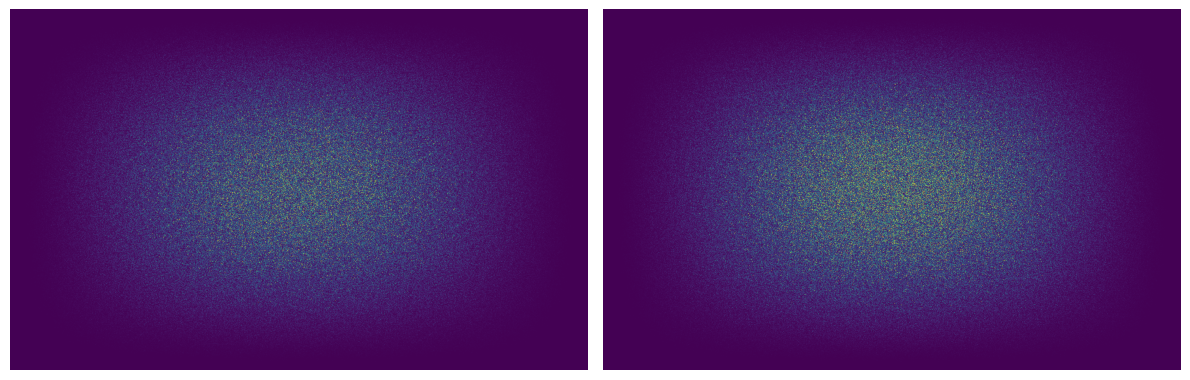

In [16]:
def quantizer_apply (tt):
    m_table = torch.Tensor([
        0.0000, 0.0100, 0.0205, 0.0422,
        0.0560, 0.0727, 0.1131, 0.1734,
        0.3426, 0.3707, 0.4228, 0.4916,
        0.5994, 0.6671, 0.7970, 0.9375
    ]).to(tt.device)

    return torch.index_select(m_table, 0, tt.reshape(-1)).reshape_as(tt)

z2 = quantizer_apply(z.to(torch.int32))
z3 = torch.exp(-1j * z2)

z4 = torch.fft.ifftshift(torch.fft.ifft2(z3)).abs().pow(2)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(z4.clamp(0, 0.000001).cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()
plt.subplot(1,2,2)

z5=t[0,:,:].unsqueeze(0).unsqueeze(0)
z5=torchvision.transforms.functional.resize(
    z5,
    size=[800,1280], 
    interpolation=torchvision.transforms.InterpolationMode.NEAREST, 
    antialias=False).squeeze()
z6 = torch.fft.ifftshift(torch.fft.ifft2(torch.exp(-1j*z5))).abs().pow(2)
plt.imshow(z6.clamp(0, 0.00001).cpu().detach().numpy())
plt.axis('off')
plt.tight_layout()
plt.show()